# Image classification - Cats vs Dogs

# Step 1 - Importing the required libraries
The libraries required throughout this project have been imported in this step

In [112]:
### Required libraries

#from google.colab import drive # For google colab setup

from glob import glob
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image
import random
from PIL import Image 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.decomposition import PCA
import statistics


from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras import layers
from keras.constraints import max_norm
from pigeon import annotate
from IPython.display import display, Image

# Google colab setup
This project was developed using both google colab and locally in jupyter notebook as well, the below two cells were used 1. For mounting the google drive to colab, to load the dataset from drive
2. Creating a new directory within colab drive and unzipping the dataset to the folder

In [2]:
### Mounting the google drive to google colab, to access the dataset
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
### Creating a folder named image process and unzipping the train data from the google drive to google colab disk
!mkdir ImageProcess

### Within the image process folder a sub-directory traindata is created to all the 1002 train images
!unzip gdrive/MyDrive/ImageProcess/TrainData.zip -d ImageProcess/TrainData> /dev/nully

# Loading image and preprocessing

### Preprocessing 1
#### 1. Loading image from the train data path
#### 2. Resizing all image to constant size 350*350
#### 3. Normalising the array to store the values between 0 to 1
#### 4. Storing the normalised data to a numpy Array

### Loading image
The images were loaded using keras library, while loading the image the target size was set to 350 * 350 for all the image

To normalise the image the array was divided by 255 to set to a common scale

The labels of the image stored in another array as 0 or 1

In [262]:
### Reading the images from the train path

##train_path = './ImageProcess/TrainData/' ## Path when using google colab

train_path = './Data/train/' ## Path when using local machine

images = []
labels = []
for filename in os.listdir(train_path):
  image_path= os.path.join(train_path, filename)

## Load the image and resize to size 350*350
  image = tf.keras.preprocessing.image.load_img(image_path, target_size=(350,350))
  image_arr = tf.keras.preprocessing.image.img_to_array(image)

## Normalise the Imgae and append to a list
  images.append(image_arr/255)

  if filename.split('.')[0] == 'dog':
    labels.append(1)
  else:
    labels.append(0)

## Converting the list to an numpy array
image_arr = np.array(images)
labels_arr = np.array(labels)

In [263]:
print("Shape of the dataset and the labels",image_arr.shape, labels_arr.shape)

Shape of the dataset and the labels (1002, 350, 350, 3) (1002,)


##### Subsample the data for more efficient code execution in this exercise

##### Data Subsampling was/will be used only for initial model building purposes, the final model training was done using the whole dataset
num_training = 600
mask = list(range(num_training))
image_arr = image_arr[mask]
labels_arr = labels_arr[mask]

### Displaying sample images of the dataset
Using the cv2 library the images were read from the directory and 16 random images have been displayed

Random images of the dataset representing dogs and cats


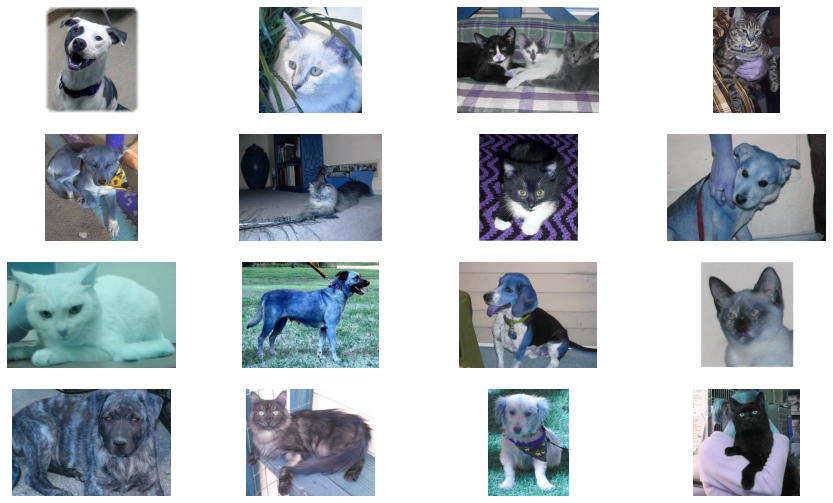

In [267]:
images = []
for image in os.listdir(train_path):
  images.append(os.path.join(train_path, image))

plt.figure(1, figsize=(15, 9))
plt.axis('off')
n = 0
for i in range(16):
  n += 1
  random_img = random.choice(images)
  imgs = cv2.imread(random_img)
  plt.subplot(4, 4, n)
  plt.axis('off')
  plt.imshow(imgs)
print("Random images of the dataset representing dogs and cats")
plt.show()

### Distribution of the dataset
TO check if the classes are equally distributed the labels have been grouped and plotted as a pie chart

In [135]:
categories = []
value = []
image = os.listdir(train_path)
for file in image:
    if file.split('.')[0] == 'dog':
        categories.append('dog')
        value.append(1)
    else:
        categories.append('cat')
        value.append(0)
        
        
image_cat_df =pd.DataFrame({
    'value': categories,
    'categories':value
    
})

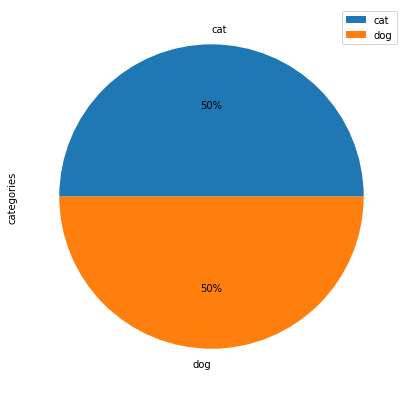

In [137]:
image_cat_df.groupby('value').count().plot(kind = 'pie', y = 'categories', autopct = '%1.0f%%', figsize=(7,7))
plt.show()

### Principal component analysis
PCA is used for dimensionality reduction

Steps, based on the code order below:

Splitting the RGB channels seperately using cv2 library

Plotting the orginal and three channels using matplotlib

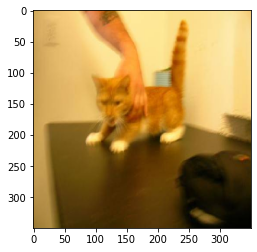

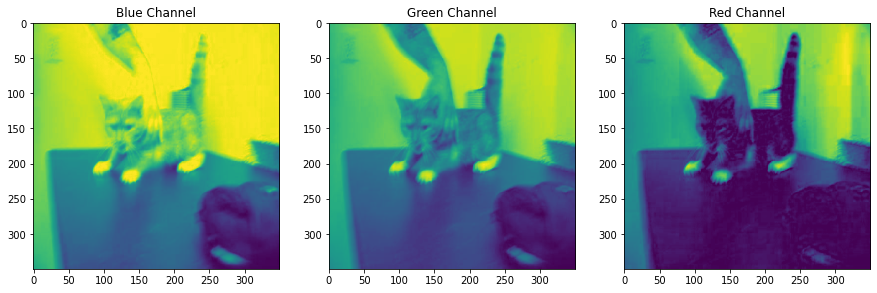

In [110]:
### Splitting all images to blue, green and red channels
blue_ch_ar=[]
green_ch_ar = []
red_ch_ar = []

for i in image_arr:
  blue,green,red = cv2.split(i)

  blue_ch_ar.append(blue)
  green_ch_ar.append(green)
  red_ch_ar.append(red)
blue_ch = np.array(blue_ch_ar)
green_ch = np.array(green_ch_ar)
red_ch = np.array(red_ch_ar)


### Plotting a random image to show blue, green and red channel seperation

### orginal image
plt.imshow(image_arr[0,:])
plt.show()


### blue, green and red channel images
fig = plt.figure(figsize = (15, 7.2)) 

fig.add_subplot(131)
plt.title("Blue Channel")
plt.imshow(blue_ch[0,:])

fig.add_subplot(132)
plt.title("Green Channel")
plt.imshow(green_ch[0,:])

fig.add_subplot(133)
plt.title("Red Channel")
plt.imshow(red_ch[0,:])
plt.show()

Reducing the number of components to 50 using PCA function in keras package

Inverse transforming the images to form get the different channels to the old shape

Merging the channels back to form the old image with less dimensions

In [6]:
pca_b = PCA(n_components=50)
pca_g = PCA(n_components=50)
pca_r = PCA(n_components=50)

blue_ch_pca = []
green_ch_pca = []
red_ch_pca = []

b_var = []
g_var = []
r_var = []

for i in blue_ch:
  pca_b.fit(i)
  trans_pca_b = pca_b.transform(i)
  b_arr_val = pca_b.inverse_transform(trans_pca_b)
  blue_ch_pca.append(b_arr_val)
  b_var.append(sum(pca_b.explained_variance_ratio_))

for j in green_ch:
  pca_g.fit(j)
  trans_pca_g = pca_g.transform(j)
  g_arr_val = pca_g.inverse_transform(trans_pca_g)
  green_ch_pca.append(g_arr_val)
  g_var.append(sum(pca_g.explained_variance_ratio_))

for k in red_ch:
  pca_r.fit(k)
  trans_pca_r = pca_r.transform(k)
  r_arr_val = pca_r.inverse_transform(trans_pca_r)
  red_ch_pca.append(r_arr_val)
  r_var.append(sum(pca_r.explained_variance_ratio_))


blue_ch_pca = np.array(blue_ch_pca)
green_ch_pca = np.array(green_ch_pca)
red_ch_pca = np.array(red_ch_pca)

Shape of PCA applied sample image for Blue channel:  (350, 50)
Shape of PCA applied sample image for Green channel:  (350, 50)
Shape of PCA applied sample image for Red channel:  (350, 50)

Shape of array after inversion transformation for blue channel:  (1002, 350, 350)
Shape of array after inversion transformation for green channel:  (1002, 350, 350)
Shape of array after inversion transformation for red channel:  (1002, 350, 350)

Blue channel variance retained with only using 50 components:  97.92
Green channel variance retained with only using 50 components:  97.82
Red channel variance retained with only using 50 components:  97.77


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Shape of array after merging blue, green and red channels:  (1002, 350, 350, 3)

Orginal image and Reduced image after PCA:


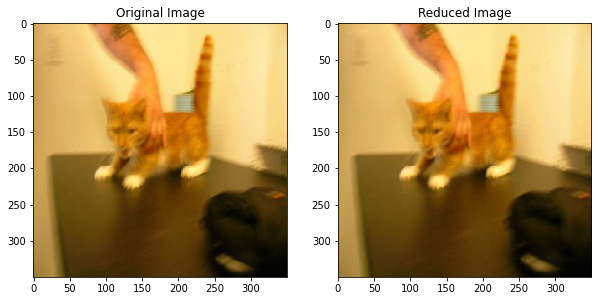

In [7]:
### The shape of PCA applied image - this depicts only shape of one sample image(final image in the array)
print("Shape of PCA applied sample image for Blue channel: ", trans_pca_b.shape)
print("Shape of PCA applied sample image for Green channel: ", trans_pca_g.shape)
print("Shape of PCA applied sample image for Red channel: ", trans_pca_r.shape)

### The shape of the array once inverse transformation was performed upon the PCA applied data
### The orginal shape of images(350*350) have been retained
print("\nShape of array after inversion transformation for blue channel: ", blue_ch_pca.shape)
print("Shape of array after inversion transformation for green channel: ", green_ch_pca.shape)
print("Shape of array after inversion transformation for red channel: ", red_ch_pca.shape)

### Getting the mean value of variance retained for each image after pca for each channel (r,g & b)
print("\nBlue channel variance retained with only using 50 components: " ,round(statistics.mean(b_var)*100,2))
print("Green channel variance retained with only using 50 components: " ,round(statistics.mean(g_var)*100,2))
print("Red channel variance retained with only using 50 components: " ,round(statistics.mean(r_var)*100,2))

### Merging the three channels together
img_reduced = []
for i in range(len(blue_ch_pca)):
  img_reduced_val = (cv2.merge((blue_ch_pca[i,:], green_ch_pca[i,:], red_ch_pca[i,:])))
  img_reduced.append(img_reduced_val)
img_reduced = np.array(img_reduced)
print("\nShape of array after merging blue, green and red channels: " ,img_reduced.shape)

print("\nOrginal image and Reduced image after PCA:")
fig = plt.figure(figsize = (10, 7.2)) 
fig.add_subplot(121)
plt.title("Original Image")
plt.imshow(image_arr[0,:])
fig.add_subplot(122)
plt.title("Reduced Image")
plt.imshow(img_reduced[0,:])
plt.show()

### Train Validation Split
The train dataset has been split into train and validation, where 20 % of the data which will be validation will be used to validate the accuracy of models during training phase

In [8]:
train_features, val_features, train_labels, val_labels = model_selection.train_test_split(img_reduced, labels_arr, test_size=0.2, random_state=0)
print("Train and test split dataframes size: ")
print(train_features.shape,train_labels.shape)
print(val_features.shape,val_labels.shape)

Train and test split dataframes size: 
(801, 350, 350, 3) (801,)
(201, 350, 350, 3) (201,)


### Flattening the array
The shape of the vectors have been converteed from multi dimensional to one dimension by flattening the vector, the dimensions 350 * 350 * 3 have been multiplied and 367500 features have been formed

In [9]:
X_train = np.reshape(train_features, (train_features.shape[0], -1))
X_test = np.reshape(val_features, (val_features.shape[0], -1))
print(X_train.shape, X_test.shape)

(801, 367500) (201, 367500)


# Model Training
KNN, SVM, Random forest and CNN models have been used for image classification model trainings

ski-kit learn was used for the machine learning algorithms and keras was used for the deep leraning algorithm

### K-Nearest Neighbors Algorithm - KNN

In [11]:
clf_knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, train_labels)
scores_knn = cross_val_score(clf_knn, X_train, train_labels, cv=10)

KNN Model training
54.31 accuracy for 10 F-CV KNN

Prediction on validation dataset


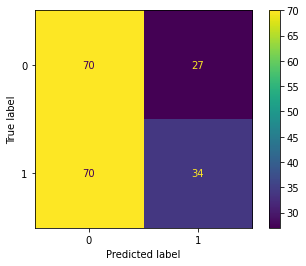

In [12]:
print("KNN Model training")
print("%0.2f accuracy for 10 F-CV KNN" % (scores_knn.mean()*100))

print("\nPrediction on validation dataset")
predictions_knn = clf_knn.predict(X_test)
cm_knn = confusion_matrix(val_labels, predictions_knn, labels=clf_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=clf_knn.classes_)
disp.plot()
plt.show()

### Support Vector Machine Algorithm - SVM

In [13]:
clf_svm = SVC(kernel='linear', C=1).fit(X_train, train_labels)
scores_svm = cross_val_score(clf_svm, X_train, train_labels, cv=10)

SVM Model training
53.56 accuracy for 10 F-CV SVM

Prediction on validation dataset


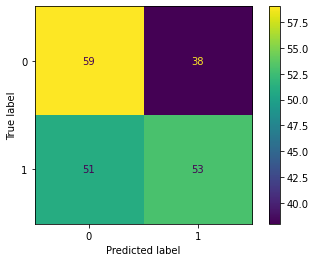

In [16]:
print("SVM Model training")
print("%0.2f accuracy for 10 F-CV SVM" % (scores_svm.mean()*100))

print("\nPrediction on validation dataset")
predictions = clf_svm.predict(X_test)
cm_svm = confusion_matrix(val_labels, predictions, labels=clf_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=clf_svm.classes_)
disp.plot()
plt.show()

### Random Forest Algorithm

In [15]:
clf_rf = RandomForestClassifier().fit(X_train, train_labels)
scores_rf = cross_val_score(clf_rf, X_train, train_labels, cv=10)
#scores_rf = cross_val_score(clf_rf, X_train, train_labels, cv=5, scoring='f1_macro')

Random Forest Model training
60.18 accuracy for 10 F-CV Random Forest

Prediction on validation dataset


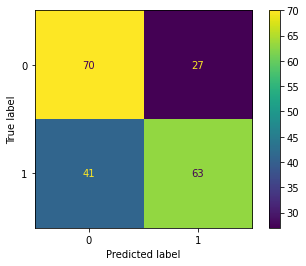

In [17]:
print("Random Forest Model training")
print("%0.2f accuracy for 10 F-CV Random Forest" % (scores_rf.mean()*100))

print("\nPrediction on validation dataset")
predictions = clf_rf.predict(X_test)
cm_rf = confusion_matrix(val_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot()
plt.show()

### Convolutional Neural Network Algorithm - CNN

### Data Augmentation

In [ ]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    layers.RandomRotation(0.3)
])

### CNN Model Training

In [182]:
classifier = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  data_augmentation,

  layers.Convolution2D(32,3,3,input_shape=(350, 350, 3),activation='relu',padding='valid'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2),
  
  layers.Convolution2D(64,3,3,activation='relu',padding='valid'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2),

  layers.Convolution2D(128,3,3,activation='relu',padding='SAME'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2),
 
#step3-flattening
  layers.Flatten(),
  layers.Dropout(0.2),

#step4-fullconnection
  layers.Dense(128,activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(1,activation='sigmoid')
])

In [183]:
classifier.build(train_features.shape)
classifier.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 350, 350, 3)       0         
                                                                 
 conv2d_84 (Conv2D)          (801, 116, 116, 32)       896       
                                                                 
 max_pooling2d_79 (MaxPoolin  (801, 58, 58, 32)        0         
 g2D)                                                            
                                                                 
 dropout_113 (Dropout)       (801, 58, 58, 32)         0         
                                                                 
 conv2d_85 (Conv2D)          (801, 19, 19, 64)         18496     
                                                                 
 max_pooling2d_80 (MaxPoolin  (801, 9, 9, 64)          0         
 g2D)                                                

In [184]:
classifier.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer= "Adam")
history = classifier.fit(train_features, train_labels, batch_size=32, epochs=20, validation_data=(val_features, val_labels))

Epoch 1/20
26/26 [==============================] - 21s 709ms/step - loss: 0.7027 - accuracy: 0.4869 - val_loss: 0.6921 - val_accuracy: 0.5174
Epoch 2/20
26/26 [==============================] - 17s 664ms/step - loss: 0.6933 - accuracy: 0.5006 - val_loss: 0.6944 - val_accuracy: 0.4826
Epoch 3/20
26/26 [==============================] - 17s 664ms/step - loss: 0.6953 - accuracy: 0.5106 - val_loss: 0.6930 - val_accuracy: 0.5124
Epoch 4/20
26/26 [==============================] - 17s 668ms/step - loss: 0.6961 - accuracy: 0.4869 - val_loss: 0.6916 - val_accuracy: 0.5224
Epoch 5/20
26/26 [==============================] - 17s 669ms/step - loss: 0.6940 - accuracy: 0.5069 - val_loss: 0.6931 - val_accuracy: 0.4876
Epoch 6/20
26/26 [==============================] - 17s 673ms/step - loss: 0.6929 - accuracy: 0.5318 - val_loss: 0.6914 - val_accuracy: 0.6219
Epoch 7/20
26/26 [==============================] - 17s 672ms/step - loss: 0.6919 - accuracy: 0.5231 - val_loss: 0.6914 - val_accuracy: 0.5075

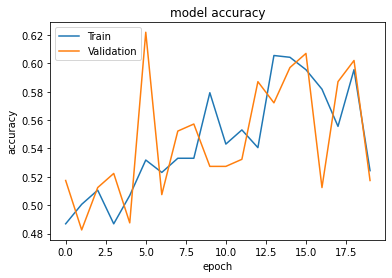

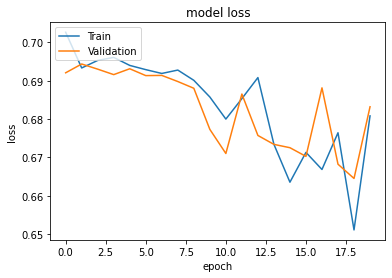

In [185]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Hyperparameter Tuning

### CNN hyperparameter tuning

In [186]:
classifierhyp = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  data_augmentation,

  layers.Convolution2D(32,3,3,input_shape=(350, 350, 3),activation='relu',padding='SAME'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.4),
  
  layers.Convolution2D(64,3,3,activation='relu',padding='SAME'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.4),
 
#step3-flattening
  layers.Flatten(),
  layers.Dropout(0.4),

#step4-fullconnection
  layers.Dense(128,activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(1,activation='sigmoid')
])

In [187]:
classifierhyp.build(train_features.shape)
classifierhyp.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 350, 350, 3)       0         
                                                                 
 conv2d_87 (Conv2D)          (801, 117, 117, 32)       896       
                                                                 
 max_pooling2d_82 (MaxPoolin  (801, 58, 58, 32)        0         
 g2D)                                                            
                                                                 
 dropout_118 (Dropout)       (801, 58, 58, 32)         0         
                                                                 
 conv2d_88 (Conv2D)          (801, 20, 20, 64)         18496     
                                                                 
 max_pooling2d_83 (MaxPoolin  (801, 10, 10, 64)        0         
 g2D)                                                

In [188]:
classifierhyp.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer= "Adam")
historyhyp = classifierhyp.fit(train_features, train_labels, batch_size=32, epochs=20, validation_data=(val_features, val_labels))

Epoch 1/20
26/26 [==============================] - 20s 687ms/step - loss: 0.7213 - accuracy: 0.5181 - val_loss: 0.6914 - val_accuracy: 0.5174
Epoch 2/20
26/26 [==============================] - 17s 675ms/step - loss: 0.6994 - accuracy: 0.4744 - val_loss: 0.6941 - val_accuracy: 0.4826
Epoch 3/20
26/26 [==============================] - 17s 684ms/step - loss: 0.6952 - accuracy: 0.4844 - val_loss: 0.6929 - val_accuracy: 0.5622
Epoch 4/20
26/26 [==============================] - 17s 669ms/step - loss: 0.6922 - accuracy: 0.5256 - val_loss: 0.6918 - val_accuracy: 0.5373
Epoch 5/20
26/26 [==============================] - 17s 673ms/step - loss: 0.6935 - accuracy: 0.5031 - val_loss: 0.6897 - val_accuracy: 0.5522
Epoch 6/20
26/26 [==============================] - 17s 678ms/step - loss: 0.6886 - accuracy: 0.5481 - val_loss: 0.6903 - val_accuracy: 0.5124
Epoch 7/20
26/26 [==============================] - 17s 673ms/step - loss: 0.6871 - accuracy: 0.5443 - val_loss: 0.6834 - val_accuracy: 0.5473

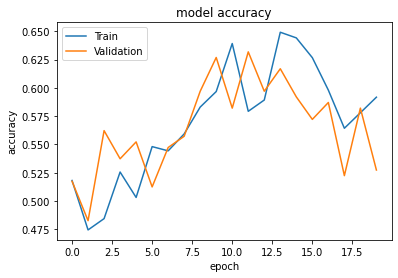

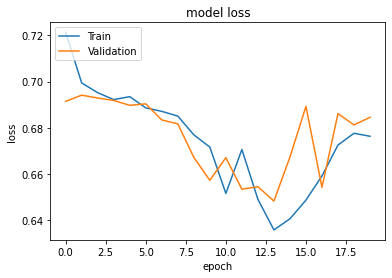

With lowest validation loss and highest accuracy of 63.18 %, 12th Epoch is the best fit model


In [269]:
# summarize history for accuracy
plt.plot(historyhyp.history['accuracy'])
plt.plot(historyhyp.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyhyp.history['loss'])
plt.plot(historyhyp.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print("With lowest validation loss and highest accuracy of 63.18 %, 12th Epoch is the best fit model")

### Random forest hyperparameter tuning
GridsearchCV was used to eavaluate the model and find the best fit model

In [147]:
hyper = {'n_estimators': [100,200], 'criterion': ["gini", "entropy"] }

gd_hyper=GridSearchCV(estimator=RandomForestClassifier(),param_grid=hyper,cv=10, scoring='f1_macro')

gd_hyper.fit(X_train, train_labels)

print("Best Score: ", gd_hyper.best_score_)
print("Best Estimatior: ", gd_hyper.best_estimator_)
nv_hyp_bst = gd_hyper.best_estimator_

Best Score:  0.6230372107300642
Best Estimatior:  RandomForestClassifier(criterion='entropy')


# Prediction of test data

### Annotation of test dataset

In [218]:
path = './Data/test/'
imgs = os.listdir(path)
imgs = [os.path.join(path, img) for img in imgs]

annotations = annotate(
  imgs,
  options=['cat', 'dog'],
  display_fn=lambda filename: display(Image(filename))
)

HTML(value='0 examples annotated, 101 examples left')

Output()

Annotation done.


In [326]:
### Reading the images from the test path


images_t = []
for filename in os.listdir(path):
  image_path= os.path.join(path, filename)

## Load the image and resize to size 350*350
  image = tf.keras.preprocessing.image.load_img(image_path, target_size=(350,350))
  image_arr = tf.keras.preprocessing.image.img_to_array(image)

## Normalise the Imgae and append to a list
  images_t.append(image_arr/255)

## Converting the list to an numpy array
image_arr_t = np.array(images_t)


### Prediction of test data

In [327]:
predictions = (classifierhyp.predict(image_arr_t) > 0.5).astype("int32")

In [328]:
anno_check = []
pred_check = []
for i in annotations:
    anno_check.append(i[1])
for i in predictions:
    pred_check.append(i[0])
    
Pred_df =pd.DataFrame({
    'Actual': anno_check,
    'Predicted':pred_check
    
})
Pred_df.loc[Pred_df['Predicted'] == 0, 'Predicted'] = 'cat'
Pred_df.loc[Pred_df['Predicted'] == 1, 'Predicted'] = 'dog'
pd.set_option('display.max_rows', None)
print("The Actual values vs the Predicted values:")
print(Pred_df)

The Actual values vs the Predicted values:
   Actual Predicted
0     dog       cat
1     cat       cat
2     cat       cat
3     cat       cat
4     dog       cat
5     cat       cat
6     cat       cat
7     cat       cat
8     cat       cat
9     dog       cat
10    dog       dog
11    cat       cat
12    dog       cat
13    cat       cat
14    dog       cat
15    cat       cat
16    dog       cat
17    dog       cat
18    cat       cat
19    dog       cat
20    dog       cat
21    cat       cat
22    cat       cat
23    dog       cat
24    dog       dog
25    dog       cat
26    dog       cat
27    dog       cat
28    cat       cat
29    cat       cat
30    cat       cat
31    cat       cat
32    cat       cat
33    dog       cat
34    dog       dog
35    cat       cat
36    dog       cat
37    dog       cat
38    dog       dog
39    dog       cat
40    cat       dog
41    dog       cat
42    cat       cat
43    dog       dog
44    dog       cat
45    cat       cat
46    cat       c

Confusion matrix for test dataset prediction

Prediction on Test dataset


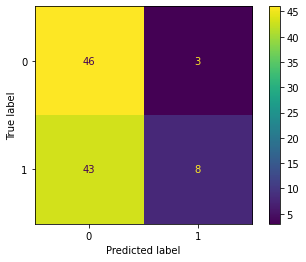

In [329]:
print("Confusion matrix for test dataset prediction")

print("\nPrediction on Test dataset")
cm_rf = confusion_matrix(Pred_df.Actual, Pred_df.Predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot()
plt.show()